## Aprendizaje No Supervisado 

## Importación de Librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
import io

## Lectura del dataset

Se carga la base de datos ya procesada con las variables de interés.

In [2]:
df_w_gk= pd.read_csv("final_df.csv")\
            .drop(columns="Unnamed: 0")
df_w_gk.head(3)

,short_position,GKDiving,Composure,Finishing,Vision,Strength,Stamina,Jumping,ShotPower,Reactions,Agility,Dribbling,HeadingAccuracy
0,front,6.0,96.0,95.0,94.0,59.0,72.0,68.0,85.0,95.0,91.0,97.0,70.0
1,front,7.0,95.0,94.0,82.0,79.0,88.0,95.0,95.0,96.0,87.0,88.0,89.0
2,midfield,9.0,94.0,87.0,87.0,49.0,81.0,61.0,80.0,94.0,96.0,96.0,62.0


## PCA con Goalkeeper

In [4]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [5]:
X_sc = df_w_gk.drop(columns="short_position")
short_position= df_w_gk.short_position

Se estandarizan los datos previo a realizar el PCA.

In [6]:
scaler = StandardScaler()
X_sc_st = scaler.fit_transform(X_sc)

In [7]:
_, nof_components = X_sc_st.shape
pcamodel = PCA(n_components=nof_components)
pca = pcamodel.fit_transform(X_sc_st)
pca.shape

(4749, 12)

Se muestra la varianza explicada acumulada por cada componente. El primer componente explica el 47,77% de la variación de los datos. Luego, la primer y segundo componente explican el 65,31% y asi sucesivamente.

In [16]:
explained_variance=pcamodel.explained_variance_ratio_
acc_variance_percent = np.cumsum(np.round(explained_variance, decimals=5) * 100)
acc_variance_percent

array([ 47.77 ,  65.311,  75.042,  82.888,  87.073,  90.495,  93.636,
        95.661,  97.261,  98.592,  99.488, 100.   ])

Teniendo en cuenta los gráficos que se muestran debajo, se eligieron las primeras 6 componentes que explican el 90,5% de la variación de los datos.

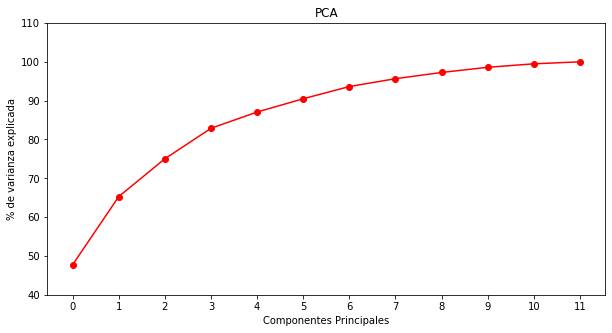

In [20]:
plt.figure(figsize=(10, 5))
plt.ylabel('% de varianza explicada')
plt.xlabel('Componentes Principales')
plt.title('PCA')
plt.ylim(40, 110)
plt.xticks(range(nof_components))
plt.plot(acc_variance_percent, 'ro-')

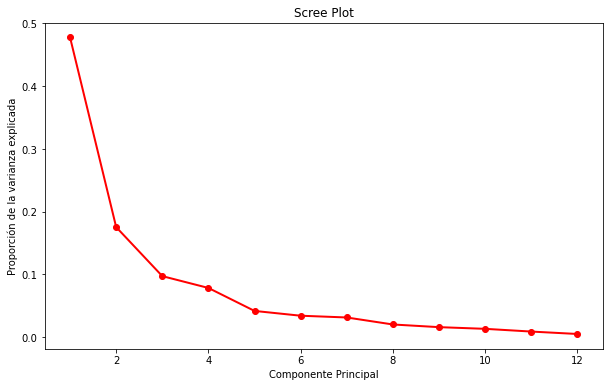

In [24]:
PC_values = np.arange(pcamodel.n_components_) + 1

plt.figure(figsize=(10,6))
plt.plot(PC_values, pcamodel.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de la varianza explicada')
plt.show()

Realizamos el biplot con las variables originales y los datos diferenciados según `short_position`. El largo de la flecha de las variables indica el grado de asociación con la componente principal.

`GKDiving` es la variable que mas aporta a PC1 y es la que separa a los arqueros del resto de las posiciones. Por otra parte, los defensores tienen valores mas altos de `Strength` respecto a los mediocampistas y delanteros. También, dicha variable es la que mas aporte a PC2. Entonces,considerando las variables seleccionadas no es posible diferenciar a los delanteros, mediocampistas y defensores.

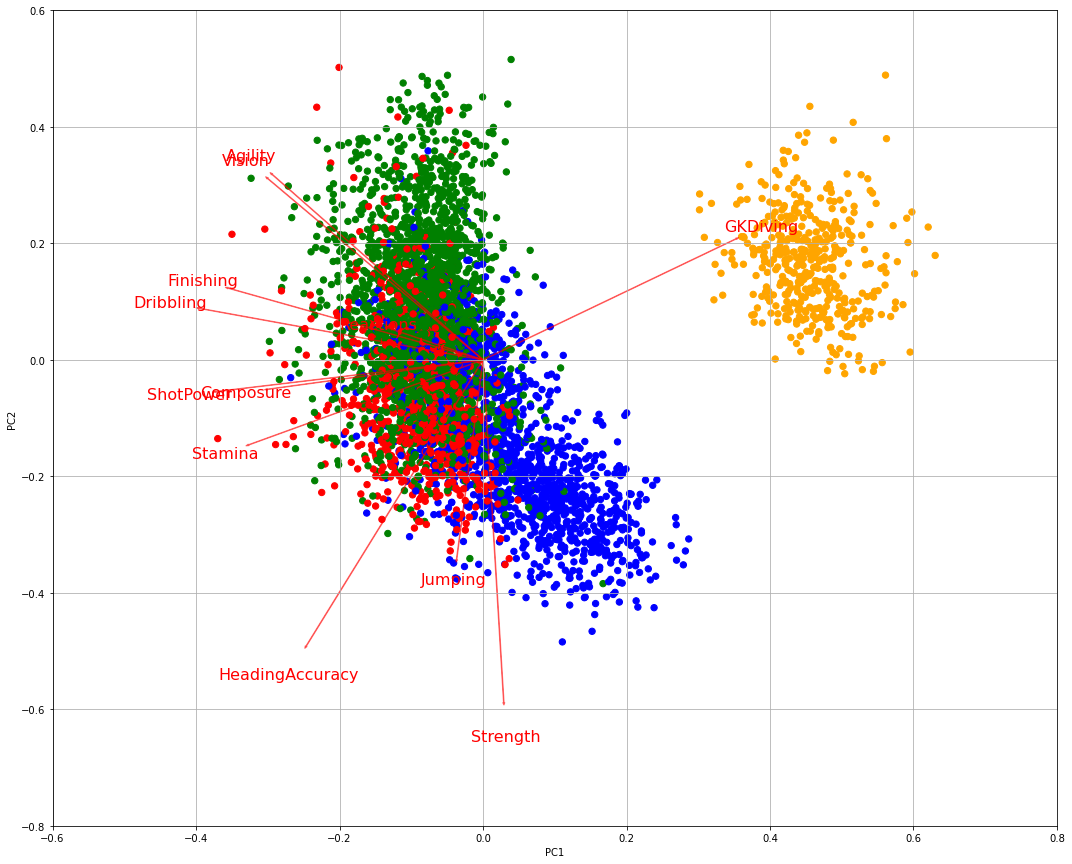

In [25]:
palette= {'front': 'red',
         'midfield': 'green',
         'goalkeeper': 'orange',
         'back': 'blue'}

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=40, c=short_position.map(palette))
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, "Var"+str(i+1), color = 'r', ha = 'center', va = 'center', fontsize= 16)
        else:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, labels[i], color = 'r', ha = 'center', va = 'center', fontsize= 16)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.ylim(-0.8, 0.6)
    plt.xlim(-0.6, 0.8)
    plt.grid()

plt.figure(figsize=(18, 15))
myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(X_sc.columns))
plt.show()


In [29]:
pca_df = pd.DataFrame(data = pca, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12'])

In [30]:
pca_df= pca_df.drop(columns=['PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12'])
pca_df.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6
0,-4.946957,1.773624,4.041766,0.187256,0.000400,-0.615178
1,-5.227239,-1.112031,4.425234,-1.261241,0.422350,0.101355
2,-4.570100,2.563992,3.531679,0.026186,-1.061535,-0.535459


## Clustering con Goalkeeper

Se realiza el clustering con Kmeans utilizando las primeras 6 componentes seleccionadas después de realizar el PCA.

### Clustering KMeans

In [31]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

In [40]:
def plot_cluster_range (X, pca, range_n_clusters):
    sse ={}
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=seed, n_init = 100 )
        cluster_labels = clusterer.fit_predict(X)
        sse[n_clusters] = clusterer.inertia_

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("Para n_clusters =", n_clusters,
              "El silhouette_score promedio es :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Visualizacion de los datos.")
        ax1.set_xlabel("espacio de la primera caracteristica")
        ax1.set_ylabel("espacio de la segunda caracteristica")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(pca[:, 0], pca[:, 1]
                    , marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')


        ax2.set_title("Visualizacion de los datos.")
        ax2.set_xlabel("espacio de la primera caracteristica")
        ax2.set_ylabel("espacio de la segunda caracteristica")

        plt.suptitle(("Analisis de silueta para Kmedias "
                      "con n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

    plt.show()

Para n_clusters = 3 El silhouette_score promedio es : 0.3120192817546181
Para n_clusters = 4 El silhouette_score promedio es : 0.2542353646216446
Para n_clusters = 5 El silhouette_score promedio es : 0.2317155719021479
Para n_clusters = 6 El silhouette_score promedio es : 0.2187393046234914


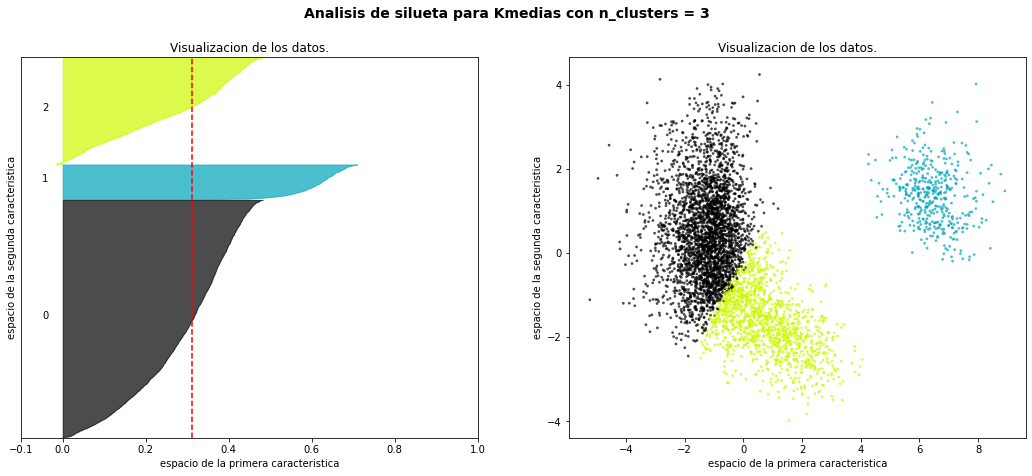

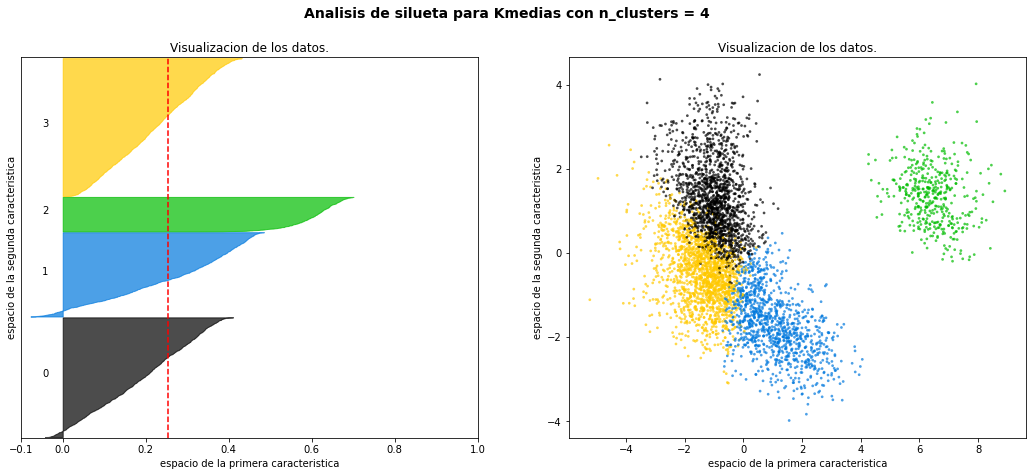

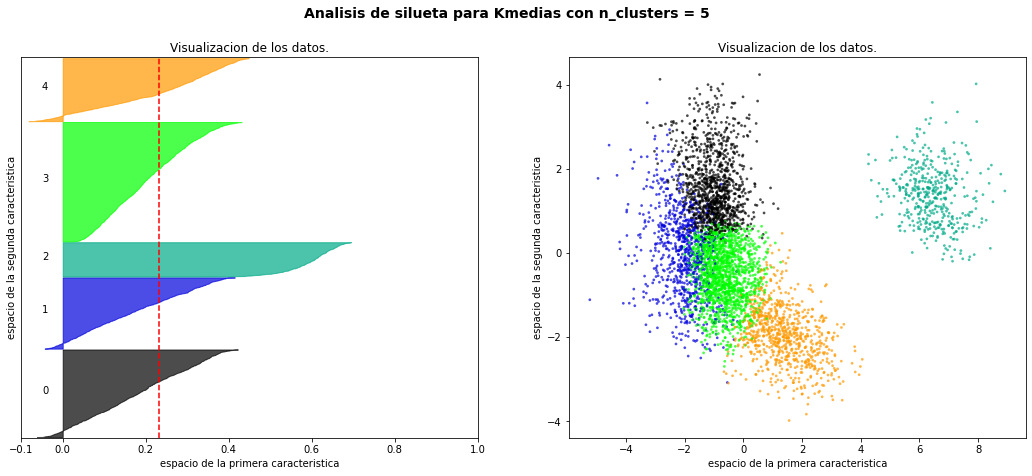

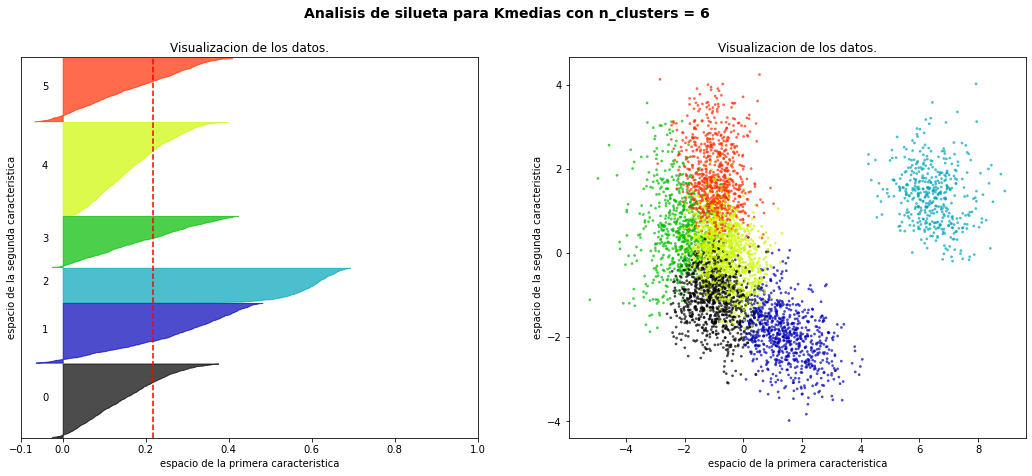

In [41]:
range_n_clusters = [3, 4, 5, 6]
plot_cluster_range(pca_df, pca, range_n_clusters)

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

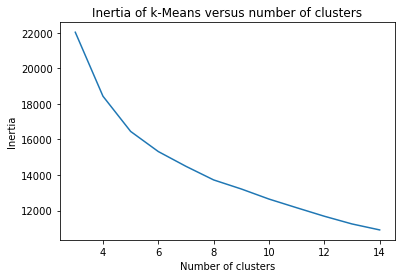

In [42]:
scores = [KMeans(n_clusters=i, random_state = 28).fit(pca_df).inertia_ for i in range(3,15)]

plt.plot(np.arange(3, 15), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Si bien no se observa un quiebre pronunciado en el gráfico del codo, se seleccionó 4 como número de clusters siendo el punto de inflexión en esta gráfica. Además, se tuvo en cuenta el gráfico de silueta asociado a este número de clusters.

#### Número de clusters seleccionado

In [43]:
n_clust = 4

km = KMeans(n_clusters=n_clust, random_state=seed)
km.fit(pca_df)

pca_df = pca_df.assign(kmeans_cluster=km.labels_)

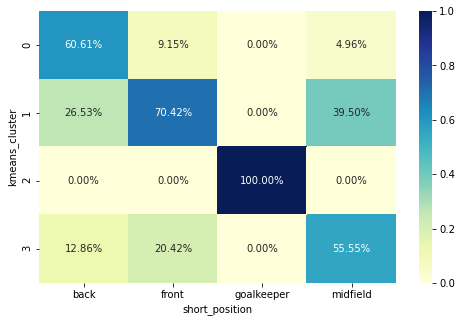

In [44]:
plt.figure(figsize=(8, 5))
exp = pd.crosstab(
    pca_df.kmeans_cluster,
    df_w_gk.short_position,
    normalize='columns')
sns.heatmap(exp, annot=True, fmt='.2%', cmap="YlGnBu")
plt.show()

Se observa que el cluster que contiene a los _Goalkeeper_ tiene una completitud de toda la clase a diferencia de los restantes clusters en donde hay heterogeneidad de clases. El cluster número 0 posee la mayoría de los defensores, mientras que el cluster número 1 posee la mayoria de los delanteros. Los centrocampistas están distribuídos entre el cluster número 1 y 3, principalmente.

In [45]:
from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score

labels_pred = pca_df.kmeans_cluster
labels_true = df_w_gk.short_position

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X_sc, labels_pred))

Silhouette Coefficient: 0.221


In [46]:
h, c, v = homogeneity_completeness_v_measure(labels_true, labels_pred)

In [46]:
print("Homogeneity: %0.3f" % h)
print("Completeness: %0.3f" % c)
print("V-measure: %0.3f" % v)

Homogeneity: 0.412
Completeness: 0.393
V-measure: 0.402


### Clustering Mean Shift

Estimated number of clusters: 2
Homogeneity: 0.246
Completeness: 0.981
V-measure: 0.394
Adjusted Rand Index: 0.177
Adjusted Mutual Information: 0.394
Silhouette Coefficient: 0.544


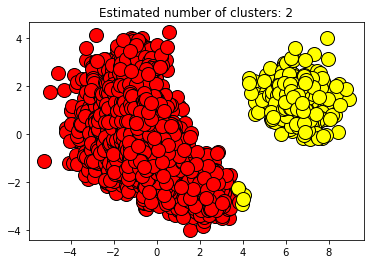

In [47]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import metrics

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(pca_df, quantile=0.5)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(pca_df)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

unique_labels = np.unique(labels)
n_clusters_ = len(unique_labels)

print('Estimated number of clusters: %d' % n_clusters_)
#print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(pca_df, labels))

# #############################################################################
# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = pca[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
   
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

El análisis de cluster realizado con MeanShift muestra un número de 2 clusters que probablemente se refieran a los _Goalkeepers_ y el resto de las posiciones agrupadas (defensores, mediocampistas y delanteros). 

## Clustering sin Goalkeeper

In [48]:
scaler = StandardScaler()
seed = 0

df_wout_gk= df_w_gk[df_w_gk.short_position!= "goalkeeper"].reset_index(drop=True)

X = df_wout_gk.drop(columns=["short_position", "GKDiving"])

X_sc_wout_gk = scaler.fit_transform(X)

In [49]:
_, nof_components = X_sc_wout_gk.shape
pcamodel_wout_gk= PCA(n_components=nof_components)
pca_wout_gk = pcamodel_wout_gk.fit_transform(X_sc_wout_gk)
pca_wout_gk.shape

(4314, 11)

Se muestra la varianza explicada acumulada por cada componente. El primer componente explica el 39,61% de la variación de los datos. Luego, el primer y segundo componente explican el 57,72% y asi sucesivamente.

In [50]:
explained_variance_wout_gk=pcamodel_wout_gk.explained_variance_ratio_
acc_variance_percent_wout_gk = np.cumsum(np.round(explained_variance_wout_gk, decimals=5) * 100)
acc_variance_percent_wout_gk

array([ 39.61 ,  57.723,  68.507,  77.072,  84.068,  88.139,  91.322,
        94.069,  96.412,  98.517, 100.001])

Se seleccionaron las primeras 7 componentes del PCA, los cuales explican el 91,32% de la variabilidad de los datos.

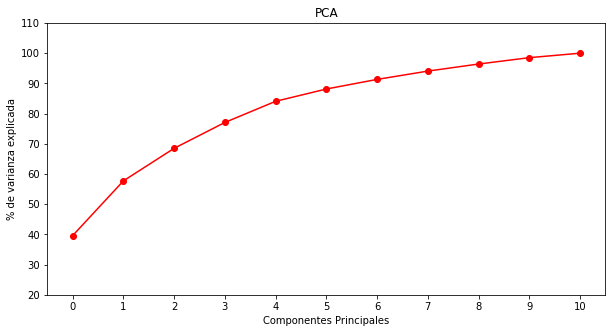

In [51]:
plt.figure(figsize=(10, 5))
plt.ylabel('% de varianza explicada')
plt.xlabel('Componentes Principales')
plt.title('PCA')
plt.ylim(20, 110)
plt.xticks(range(nof_components))
plt.plot(acc_variance_percent_wout_gk, 'ro-')

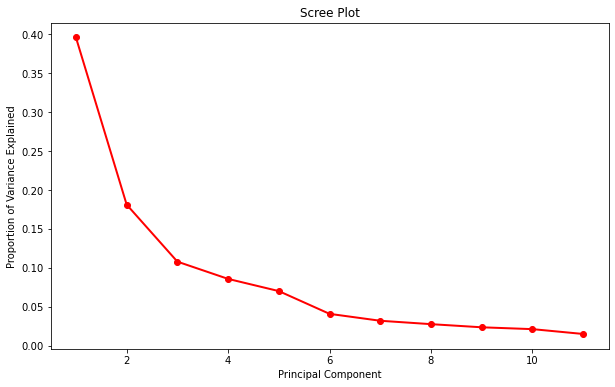

In [52]:
PC_values_wout_gk = np.arange(pcamodel_wout_gk.n_components_) + 1

plt.figure(figsize=(10,6))
plt.plot(PC_values_wout_gk, pcamodel_wout_gk.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

El biplot realizado no permite diferenciar a los defensores, mediocampistas y a los delanteros. La mayoría de los defensores tienen valores altos de `Strenght` y `HeadingAccuracy`, los cuales a los vez son las varibales que mas aportan a la primera componente del PCA. 

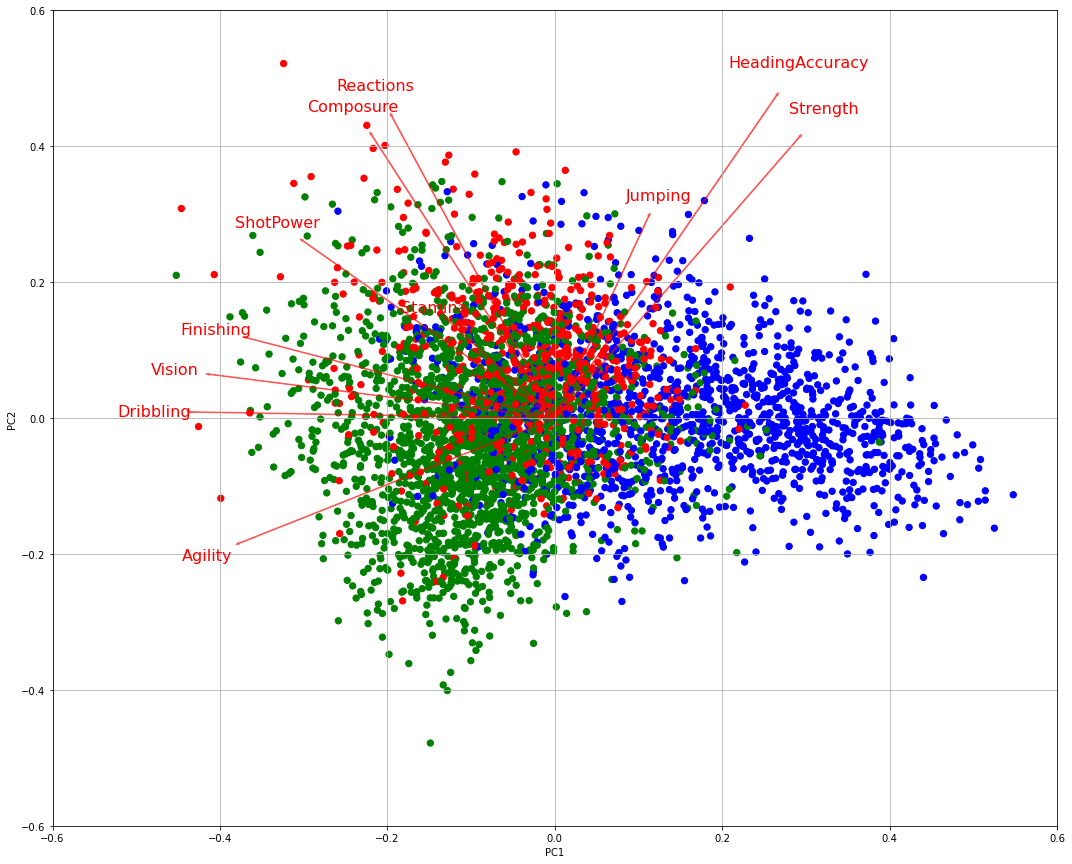

In [53]:
palette_wout_gk= {'front': 'red',
         'midfield': 'green',
         'back': 'blue'}
short_position_wout_out=df_wout_gk.short_position

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=40, c=short_position_wout_out.map(palette_wout_gk))
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, "Var"+str(i+1), color = 'r', ha = 'center', va = 'center', fontsize= 16)
        else:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.1, labels[i], color = 'r', ha = 'center', va = 'center', fontsize= 16)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.ylim(-0.6, 0.6)
    plt.xlim(-0.6, 0.6)
    plt.grid()

plt.figure(figsize=(18, 15))
myplot(pca_wout_gk[:,0:2],np.transpose(pcamodel_wout_gk.components_[0:2, :]),list(X.columns))
plt.show()


In [54]:
pca_df_wout_gk = pd.DataFrame(data = pca_wout_gk, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11'])

In [55]:
pca_df_wout_gk= pca_df_wout_gk.drop(columns=['PC8', 'PC9', 'PC10', 'PC11'])
pca_df_wout_gk.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-5.736780,3.765847,0.799298,1.951354,1.598907,0.682877,-0.316787
1,-4.166225,6.370512,-1.056732,0.419774,1.136523,0.590958,0.135204
2,-5.815852,2.565206,-0.018230,2.633490,1.069112,0.895526,-0.079714


### Clustering KMeans

Para n_clusters = 2 El silhouette_score promedio es : 0.2987842300077575
Para n_clusters = 3 El silhouette_score promedio es : 0.2022126323419503
Para n_clusters = 4 El silhouette_score promedio es : 0.1809067134128773
Para n_clusters = 5 El silhouette_score promedio es : 0.17009020603076053
Para n_clusters = 6 El silhouette_score promedio es : 0.14527798672292294


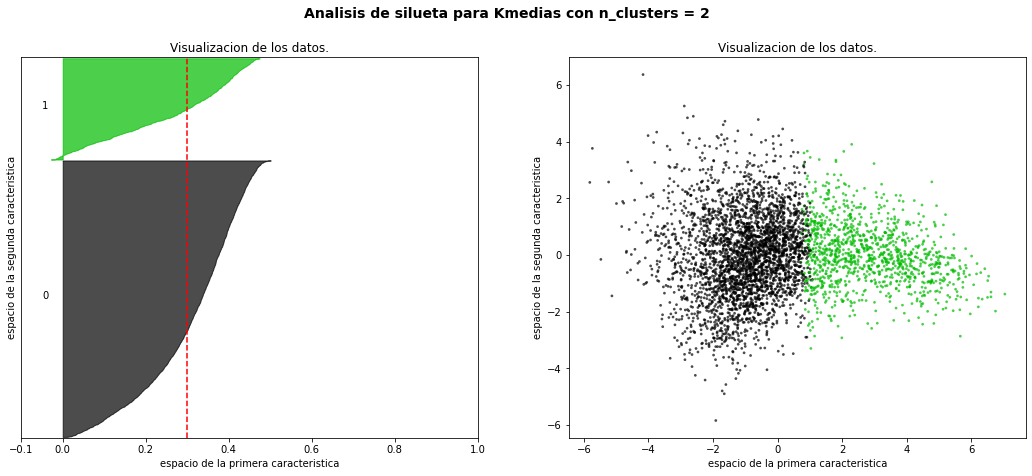

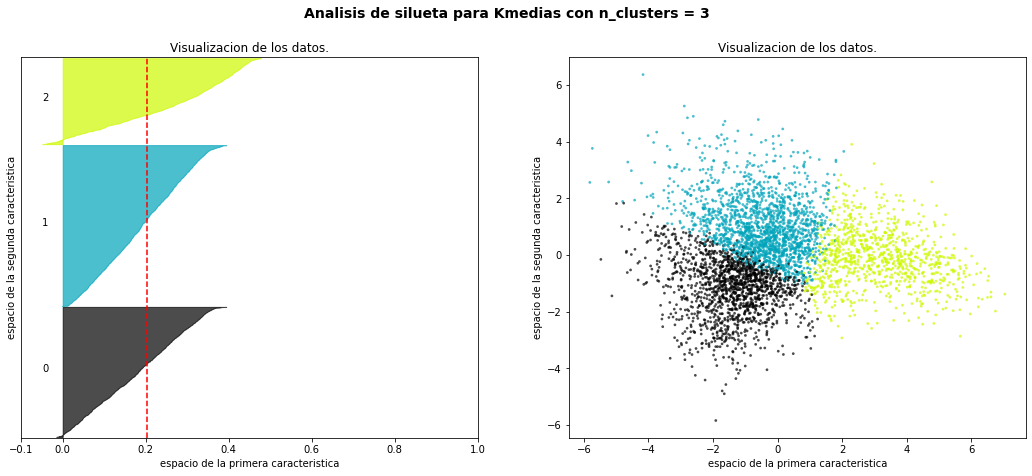

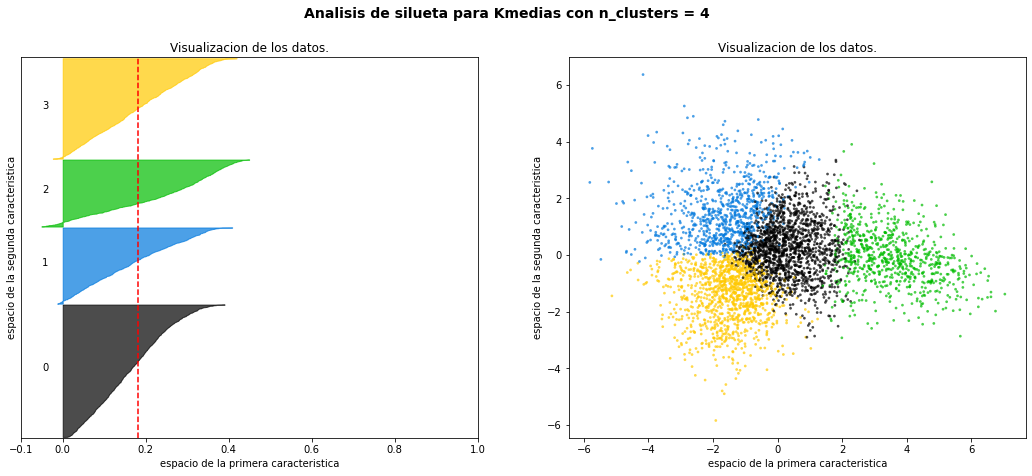

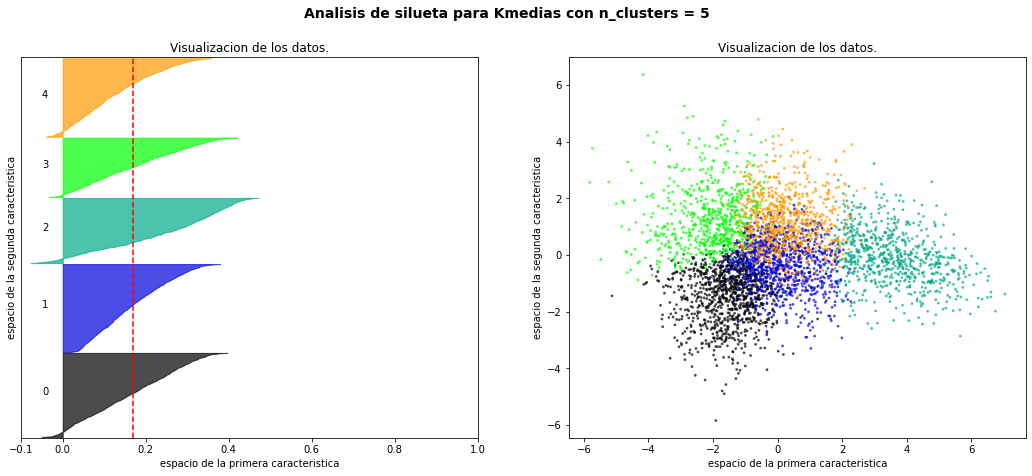

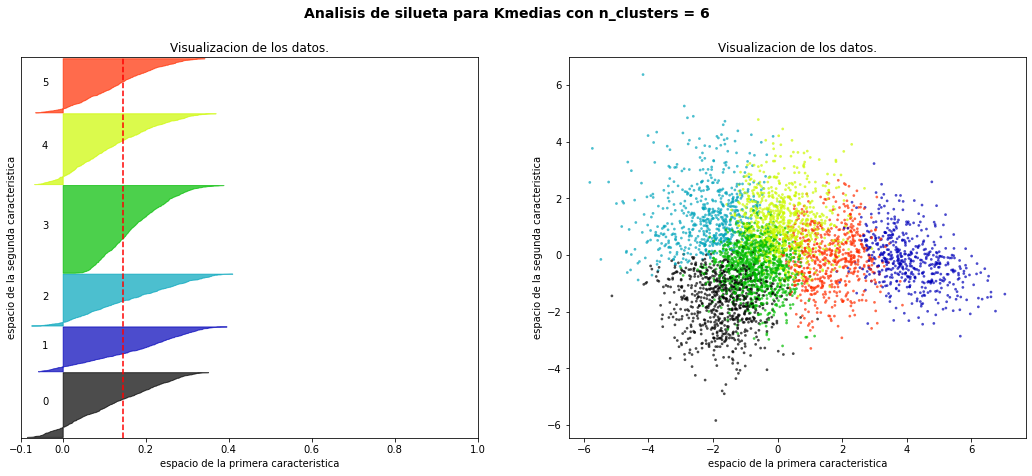

In [56]:
range_n_clusters = [2, 3, 4, 5, 6]
plot_cluster_range(pca_df_wout_gk, pca_wout_gk, range_n_clusters)

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

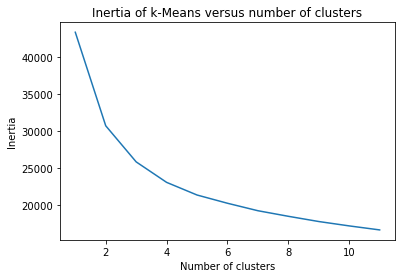

In [57]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 12 clusters
scores = [KMeans(n_clusters=i, random_state = seed).fit(pca_df_wout_gk).inertia_ for i in range(1,12)]

plt.plot(np.arange(1, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Observamos un punto de inflexión para el nivel de clusters 3.

#### Número de clusters seleccionado

In [58]:
n_clust = 3

km = KMeans(n_clusters=n_clust, random_state=seed)
km.fit(pca_df_wout_gk)

pca_df_wout_gk = pca_df_wout_gk.assign(kmeans_cluster=km.labels_)

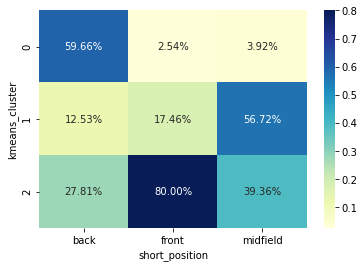

In [59]:
exp = pd.crosstab(
    pca_df_wout_gk.kmeans_cluster,
    df_wout_gk.short_position,
    normalize='columns')
sns.heatmap(exp, annot=True, fmt='.2%', cmap="YlGnBu")
plt.show()

Observamos que la posición delanteros está en su mayoría en el cluster 2, la posición de defensores en su mayoría en el cluster 0 y la posición mediocampistas está en su mayoría en el cluster 1. Tanto los defensores como los mediocampistas se encuentran más repartidos entre los diferentes clusters, lo cual explica las métrica bajas que calculamos a continuación. 
También podemos concluir que los menores valores de estas métricas se pueden deber al hecho de haber sacado a los arqueros en la búsqueda de clusters.  

In [60]:
labels_pred = pca_df_wout_gk.kmeans_cluster
labels_true = df_wout_gk.short_position

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X_sc_wout_gk, labels_pred))

Silhouette Coefficient: 0.179


In [61]:
h, c, v = homogeneity_completeness_v_measure(labels_true, labels_pred)

In [62]:
print("Homogeneity: %0.3f" % h)
print("Completeness: %0.3f" % c)
print("V-measure: %0.3f" % v)

Homogeneity: 0.252
Completeness: 0.239
V-measure: 0.245


### Clustering Mean Shift

Estimated number of clusters: 8
Homogeneity: 0.229
Completeness: 0.259
V-measure: 0.243
Adjusted Rand Index: 0.206
Adjusted Mutual Information: 0.242


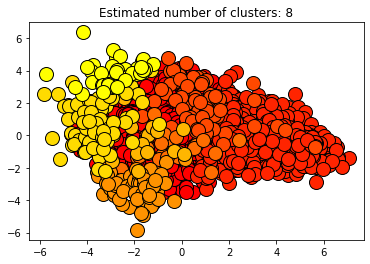

In [63]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import metrics

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(pca_df_wout_gk, quantile=0.05)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(pca_df_wout_gk)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

unique_labels = np.unique(labels)
n_clusters_ = len(unique_labels)

print('Estimated number of clusters: %d' % n_clusters_)
#print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X_sc_wout_gk, labels))

# #############################################################################
# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = pca_wout_gk[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
   
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()